In [1]:
import sys
sys.path.append('..')

In [2]:
import arviz as az
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pymc3 as pm
import pandas as pd
from helpers import posterior_grid_approx

# 2. SMALL WORLDS AND LARGE WORLDS

In [3]:
def lfilter(*args, **kwargs):
    return list(filter(*args, **kwargs))

### Code 2.1

In [4]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

### Code 2.2

In [5]:
stats.binom.pmf(6, n=9, p=.5)

0.16406250000000006

### Code 2.3 - Code 2.5 

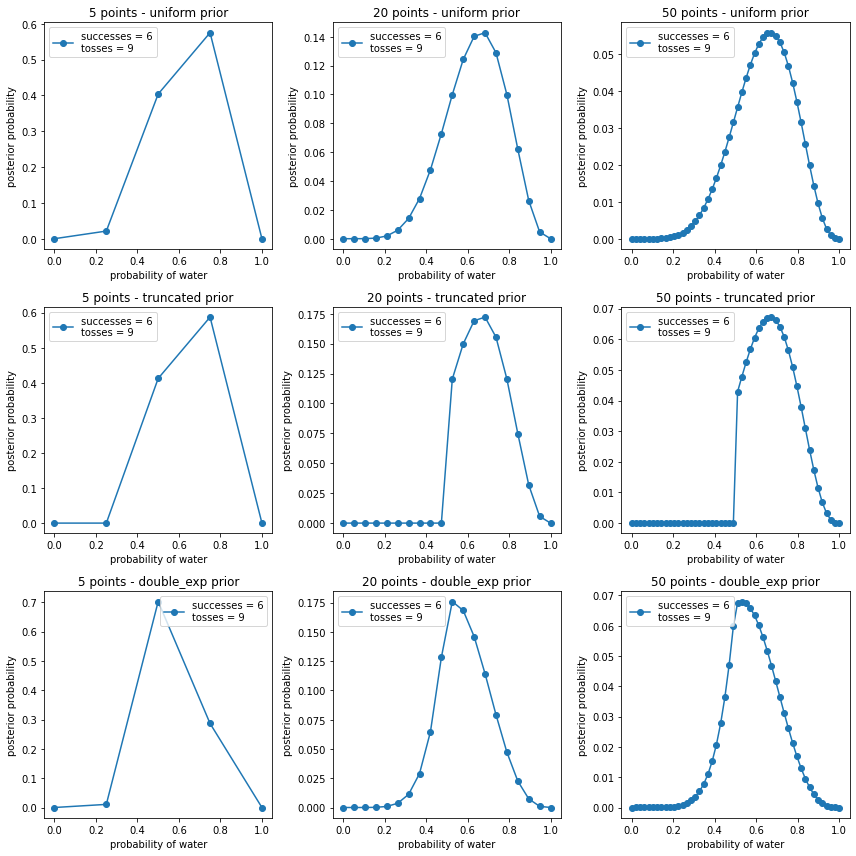

In [6]:
w, n = 6, 9

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, prior in enumerate(['uniform', 'truncated', 'double_exp']):
    for j, ps in enumerate([5, 20, 50]):
        p_grid, posterior = posterior_grid_approx(ps, w, n, prior)
        axes[i, j].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
        axes[i, j].set_xlabel("probability of water")
        axes[i, j].set_ylabel("posterior probability")
        axes[i, j].set_title(f"{ps} points - {prior} prior")
        axes[i, j].legend(loc=0)
        
fig.tight_layout()

### Code 2.6

In [7]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_approximation:
    p = pm.Uniform("p", 0, 1)  # uniform priors
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
    mean_q = pm.find_MAP()
    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

# display summary of quadratic approximation
print("Mean, Standard deviation\np {:.2}, {:.2}".format(mean_q["p"], std_q[0]))


Mean, Standard deviation
p 0.67, 0.16


In [8]:
# Compute the 89% percentile interval
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print("5.5%, 94.5% \n{:.2}, {:.2}".format(pi[0], pi[1]))

5.5%, 94.5% 
0.42, 0.92


### Code 2.7

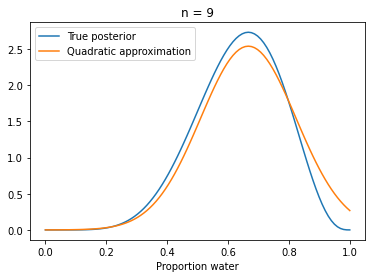

In [9]:
# analytical calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w + 1, n - w + 1), label="True posterior")

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
plt.legend(loc=0)

plt.title(f"n = {n}")
plt.xlabel("Proportion water");

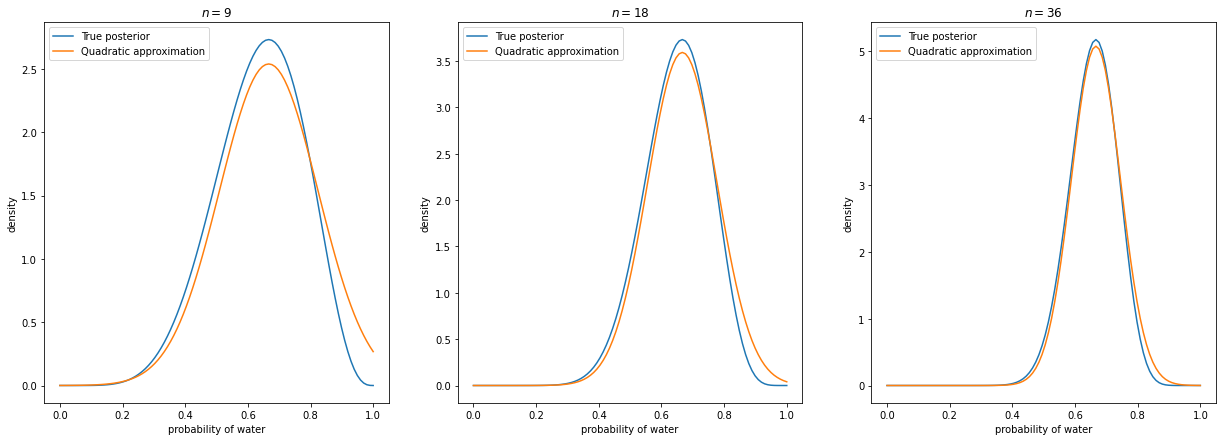

In [10]:
# Figure 2.8
x = np.linspace(0, 1, 100)
w, n = [6, 12, 24], [9, 18, 36]

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

for idx, ps in enumerate(zip(w, n)):
    data = np.repeat((0, 1), (ps[1] - ps[0], ps[0]))
    with pm.Model() as normal_approximation:
        p = pm.Uniform("p", 0, 1)  # uniform priors
        w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
        mean_q = pm.find_MAP()
        std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

    ax[idx].plot(x, stats.beta.pdf(x, ps[0] + 1, ps[1] - ps[0] + 1), label="True posterior")
    ax[idx].plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("density")
    ax[idx].set_title(r"$n={}$".format(ps[1]))
    ax[idx].legend(loc="upper left")



### Code 2.8

In [11]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = .5
w = 6
l = 3
for i in range(1, n_samples):
    pnew = stats.norm(p[i - 1], 0.1).rvs(1)
    if pnew < 0:
        pnew = abs(pnew)
    if pnew > 1:
        pnew = 2 - pnew
        
    q0 = stats.binom.pmf(w, n=w+l, p=p[i-1])
    q1 = stats.binom.pmf(w, n=w+l, p=pnew)
    
    if stats.uniform.rvs(0) < q1/q0:
        p[i] = pnew
    else:
        p[i] = p[i-1]

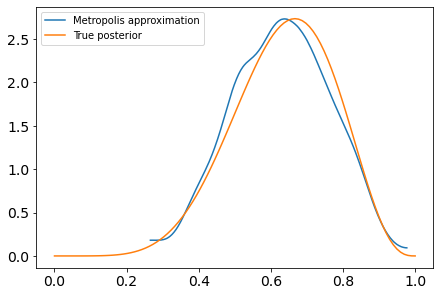

In [12]:
az.plot_kde(p, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w + 1, l + 1), "C1", label="True posterior")
plt.legend();